# Classification Hypernetwork Test

In [ ]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !tar -xvf VOCtrainval_11-May-2012.tar

In [ ]:
# !python train.py

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn

import argparse

import torch.optim as optim

from primary_net import PrimaryNetwork

#Data Loader for VOC2012
import torchvision.datasets as datasets

from torchvision.datasets import VOCDetection
import torch

class CustomVOCDataset(VOCDetection):
    def __init__(self, root, year='2012', image_set='train', transform=None, target_transform=None):
        super(CustomVOCDataset, self).__init__(root, year=year, image_set=image_set, transform=transform, target_transform=target_transform)
        self.classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

    def __getitem__(self, index):
        img, target = super(CustomVOCDataset, self).__getitem__(index)
        
        lbl = torch.zeros(len(self.classes))
        for obj in target['annotation']['object']:
            if obj['name'] in self.classes:
                class_idx = self.classes.index(obj['name'])
                lbl[class_idx] = 1
        
        return img, lbl

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
data_dir = 'VOCdevkit/VOC2012/'  # adjust if necessary

train_dataset = CustomVOCDataset(root=data_dir, year='2012', image_set='train', transform=transform)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = CustomVOCDataset(root=data_dir, year='2012', image_set='val', transform=transform)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


In [2]:
#check the dimension of trainloader images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(torch.tensor(images).size())

torch.Size([32, 3, 256, 256])


/tmp/ipykernel_22222/2414598861.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.tensor(images).size())


In [3]:
from primary_net import PrimaryNetwork

net = PrimaryNetwork()
best_accuracy = 0.

net.cuda()

learning_rate = 0.002
weight_decay = 0.0005
milestones = [168000, 336000, 400000, 450000, 550000, 600000]
max_iter = 100000

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=milestones, gamma=0.5)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()  # This is used for multi-label classification


total_iter = 0
epochs = 0
print_freq = 50

In [4]:
def validate(net, valloader, criterion):
    net.eval()
    val_loss = 0.0
    correct_labels = 0
    total_samples = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valloader):
            inputs, labels = inputs.cuda(), labels.cuda()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted_labels = outputs > 0.5  # Threshold the outputs
            total_samples += labels.size(0)
            correct_labels += (predicted_labels == labels.byte()).sum().item()

    avg_val_loss = val_loss / len(valloader)
    accuracy = 100 * correct_labels / (total_samples * len(classes))  # Calculating accuracy over all classes
    
    return avg_val_loss, accuracy

In [5]:
while total_iter < max_iter:

    running_loss = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        # print(inputs.size())
        outputs = net(inputs)
        # print(outputs.size())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        lr_scheduler.step()

        running_loss += loss.data
        if i % print_freq == (print_freq-1):
            print("[Epoch %d, Total Iterations %6d] Loss: %.4f" % (epochs + 1, total_iter + 1, running_loss/print_freq))
            running_loss = 0.0

        total_iter += 1

    epochs += 1
    # At the end of each epoch, or whenever you want to check performance on the validation set:
    val_loss, val_accuracy = validate(net, valloader, criterion)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')







[Epoch 1, Total Iterations     50] Loss: 0.3089
[Epoch 1, Total Iterations    100] Loss: 0.2470
[Epoch 1, Total Iterations    150] Loss: 0.2409
Validation Loss: 0.2400, Validation Accuracy: 92.41%
[Epoch 2, Total Iterations    229] Loss: 0.2456
[Epoch 2, Total Iterations    279] Loss: 0.2430
[Epoch 2, Total Iterations    329] Loss: 0.2415
Validation Loss: 0.2376, Validation Accuracy: 92.40%
[Epoch 3, Total Iterations    408] Loss: 0.2427
[Epoch 3, Total Iterations    458] Loss: 0.2421
[Epoch 3, Total Iterations    508] Loss: 0.2403
Validation Loss: 0.2376, Validation Accuracy: 92.40%
[Epoch 4, Total Iterations    587] Loss: 0.2425
[Epoch 4, Total Iterations    637] Loss: 0.2414
[Epoch 4, Total Iterations    687] Loss: 0.2404
Validation Loss: 0.2368, Validation Accuracy: 92.40%
[Epoch 5, Total Iterations    766] Loss: 0.2406
[Epoch 5, Total Iterations    816] Loss: 0.2426
[Epoch 5, Total Iterations    866] Loss: 0.2413
Validation Loss: 0.2366, Validation Accuracy: 92.40%
[Epoch 6, Total

KeyboardInterrupt: 

# Segmentation Hypernetwork Test

In [32]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn

import argparse

import torch.optim as optim

from primary_net import PrimaryNetwork

#Data Loader for VOC2012
import torchvision.datasets as datasets

from torchvision.datasets import VOCDetection
import torch

import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a consistent size
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),  # For masks, use nearest neighbor interpolation
    transforms.ToTensor(),
])



data_dir = 'VOCdevkit/VOC2012/'  # adjust if necessary

# Load PASCAL VOC train and validation datasets
train_dataset = VOCSegmentation(root=data_dir , year='2012', image_set='train', download=False, transform=transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root=data_dir, year='2012', image_set='val', transform=transform, target_transform=target_transform)

# Create DataLoader instances
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)


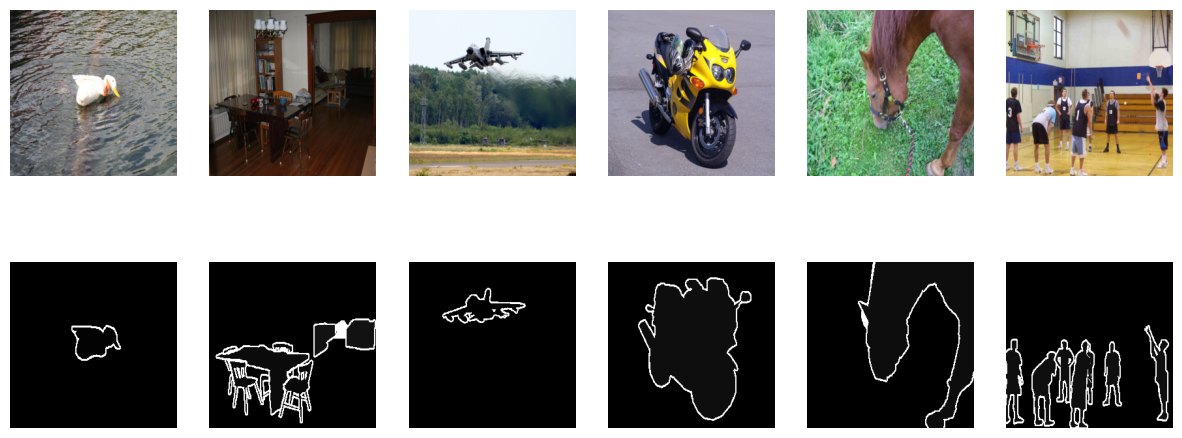

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize and convert tensor to numpy for visualization
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Get a batch of data
data_iter = iter(train_loader)
images, masks = next(data_iter)
masks = masks * 255
# # Denormalize images
# mean = [0.485, 0.456, 0.406]
# std = [0.229, 0.224, 0.225]
# images = denormalize(images, mean, std)

# Number of images to display
num_images = 6

fig, axarr = plt.subplots(2, num_images, figsize=(15, 6))

# Display images and masks
for idx in range(num_images):
    axarr[0, idx].imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
    axarr[0, idx].axis('off')
    
    axarr[1, idx].imshow(masks[idx].squeeze().numpy(), cmap='gray')
    axarr[1, idx].axis('off')

plt.show()


tensor([0.0000, 0.0039, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314, 0.0353,
        0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667, 0.0706,
        0.0745, 1.0000])


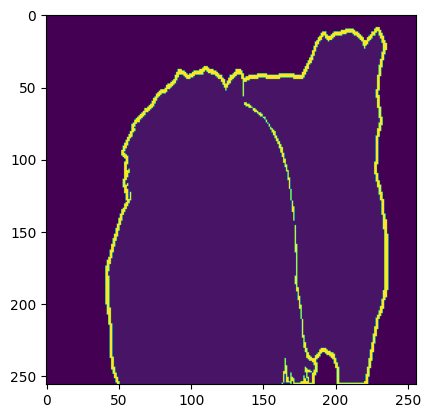

In [16]:
images, masks = next(data_iter)

print(torch.unique(masks.squeeze(1)))

plt.imshow(masks[0].squeeze(0).numpy())

In [45]:
from segmentation_net import SegmentationNetwork
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 21  # PASCAL VOC has 20 classes + 1 background class
net = SegmentationNetwork(num_classes=num_classes) 
net.cuda()

# Use CrossEntropyLoss for pixel-wise comparison
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print_freq = 50

num_epochs = 1000
for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) 
        labels = labels * 255
        labels = F.interpolate(labels, size=(512, 512), mode='nearest').squeeze(1).long()
        labels[labels == 255] = 0

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)  # Ensure your masks are in long format

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # break

        # Print statistics
        if i % 10 == 9:  # Print every 10 batches
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

    # After each epoch, you might want to evaluate on a validation set and possibly save the model

print("Finished Training")

[Epoch 1, Batch 10] loss: 2.867
[Epoch 1, Batch 20] loss: 1.962
[Epoch 1, Batch 30] loss: 1.602
[Epoch 1, Batch 40] loss: 1.385
[Epoch 2, Batch 10] loss: 1.229
[Epoch 2, Batch 20] loss: 1.236
[Epoch 2, Batch 30] loss: 1.257
[Epoch 2, Batch 40] loss: 1.287
[Epoch 3, Batch 10] loss: 1.230
[Epoch 3, Batch 20] loss: 1.216
[Epoch 3, Batch 30] loss: 1.229
[Epoch 3, Batch 40] loss: 1.208
[Epoch 4, Batch 10] loss: 1.176
[Epoch 4, Batch 20] loss: 1.265
[Epoch 4, Batch 30] loss: 1.195
[Epoch 4, Batch 40] loss: 1.205
[Epoch 5, Batch 10] loss: 1.189
[Epoch 5, Batch 20] loss: 1.235
[Epoch 5, Batch 30] loss: 1.178
[Epoch 5, Batch 40] loss: 1.208
[Epoch 6, Batch 10] loss: 1.122
[Epoch 6, Batch 20] loss: 1.179
[Epoch 6, Batch 30] loss: 1.253
[Epoch 6, Batch 40] loss: 1.181
[Epoch 7, Batch 10] loss: 1.315
[Epoch 7, Batch 20] loss: 1.149
[Epoch 7, Batch 30] loss: 1.147
[Epoch 7, Batch 40] loss: 1.096
[Epoch 8, Batch 10] loss: 1.148
[Epoch 8, Batch 20] loss: 1.191
[Epoch 8, Batch 30] loss: 1.151
[Epoch 8

In [70]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

print_freq = 50

num_epochs = 100
for epoch in range(num_epochs):
    net.train()  # Set the model to training mode
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) 
        labels = labels * 255
        labels = F.interpolate(labels, size=(512, 512), mode='nearest').squeeze(1).long()
        labels[labels == 255] = 0

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)  # Ensure your masks are in long format

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # break

        # Print statistics
        if i % 10 == 9:  # Print every 10 batches
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

    # After each epoch, you might want to evaluate on a validation set and possibly save the model

print("Finished Training")

[Epoch 1, Batch 10] loss: 1.322
[Epoch 1, Batch 20] loss: 1.268
[Epoch 1, Batch 30] loss: 1.255
[Epoch 1, Batch 40] loss: 1.252
[Epoch 2, Batch 10] loss: 1.245
[Epoch 2, Batch 20] loss: 1.297
[Epoch 2, Batch 30] loss: 1.262
[Epoch 2, Batch 40] loss: 1.223
[Epoch 3, Batch 10] loss: 1.267
[Epoch 3, Batch 20] loss: 1.295
[Epoch 3, Batch 30] loss: 1.292
[Epoch 3, Batch 40] loss: 1.216
[Epoch 4, Batch 10] loss: 1.268
[Epoch 4, Batch 20] loss: 1.221
[Epoch 4, Batch 30] loss: 1.285
[Epoch 4, Batch 40] loss: 1.320
[Epoch 5, Batch 10] loss: 1.283
[Epoch 5, Batch 20] loss: 1.334
[Epoch 5, Batch 30] loss: 1.176
[Epoch 5, Batch 40] loss: 1.277
[Epoch 6, Batch 10] loss: 1.246
[Epoch 6, Batch 20] loss: 1.269
[Epoch 6, Batch 30] loss: 1.291
[Epoch 6, Batch 40] loss: 1.219
[Epoch 7, Batch 10] loss: 1.244
[Epoch 7, Batch 20] loss: 1.315
[Epoch 7, Batch 30] loss: 1.272
[Epoch 7, Batch 40] loss: 1.329
[Epoch 8, Batch 10] loss: 1.291
[Epoch 8, Batch 20] loss: 1.243
[Epoch 8, Batch 30] loss: 1.226
[Epoch 8

In [36]:
torch.unique(labels)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 18, 19,
        20], device='cuda:0')

In [35]:
outputs.shape

torch.Size([32, 21, 512, 512])

In [37]:
torch.unique(outputs)

tensor([-1.0684, -0.9427, -0.8707,  ...,  0.8305,  0.8380,  0.8879],
       device='cuda:0', grad_fn=<Unique2Backward0>)

In [9]:
loss = criterion(outputs, labels)

In [6]:
from torchviz import make_dot
images, masks = Variable(images.cuda()), Variable(masks.cuda())
y = net(images)
make_dot(y.mean(), params=dict(net.named_parameters())).render("visualization", format="png")


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.707909 to fit


'visualization.png'

In [7]:
def get_unique_values(loader):
    all_unique_values = set()
    for _, masks in loader:
        unique_values = torch.unique(masks).tolist()
        all_unique_values.update(unique_values)
    return sorted(list(all_unique_values))

unique_values = get_unique_values(train_loader)
print("Unique values in the masks:", unique_values)


Unique values in the masks: [0.0, 0.003921568859368563, 0.007843137718737125, 0.0117647061124444, 0.01568627543747425, 0.019607843831181526, 0.0235294122248888, 0.027450980618596077, 0.0313725508749485, 0.03529411926865578, 0.03921568766236305, 0.04313725605607033, 0.0470588244497776, 0.05098039284348488, 0.054901961237192154, 0.05882352963089943, 0.062745101749897, 0.06666667014360428, 0.07058823853731155, 0.07450980693101883, 0.0784313753247261, 1.0]


In [13]:
print([ i * 255 for i in unique_values])

[0.0, 1.0000000591389835, 2.000000118277967, 3.000000058673322, 4.000000236555934, 5.000000176951289, 6.000000117346644, 7.000000057742, 8.000000473111868, 9.000000413507223, 10.000000353902578, 11.000000294297934, 12.000000234693289, 13.000000175088644, 14.000000115484, 15.000000055879354, 16.000000946223736, 17.00000088661909, 18.000000827014446, 19.0000007674098, 20.000000707805157, 255.0]


In [67]:
def validate(model, val_loader, criterion, device):
    model.eval()

    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels * 255
            labels = F.interpolate(labels, size=(512, 512), mode='nearest').squeeze(1).long()
            labels[labels == 255] = 0

            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate mIoU for segmentation evaluation
            predicted = torch.argmax(outputs, dim=1)
            iou = iou_pytorch(predicted, labels)
            total_iou += iou

            total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    avg_iou = total_iou / total_samples

    return avg_loss, avg_iou

def mean_iou(predicted, labels, num_classes=21):
    """ Compute the mean IoU """
    miou = 0.0
    for i in range(num_classes):
        intersection = ((predicted == i) & (labels == i)).float().sum()
        union = ((predicted == i) | (labels == i)).float().sum()
        
        if union == 0:
            continue
            
        miou += intersection / union
    return (miou / num_classes).item()


In [68]:
validate(net, val_loader, criterion, device)

(0.04684903105017726, tensor(0.0002, device='cuda:0'))

In [65]:
import torch
import numpy as np 


# PyTroch version

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch

def validate(model, val_loader, criterion, device):
    model.eval()

    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels * 255
            labels = F.interpolate(labels, size=(512, 512), mode='nearest').squeeze(1).long()
            labels[labels == 255] = 0

            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate mIoU for segmentation evaluation
            predicted = torch.argmax(outputs, dim=1)
            iou = iou_pytorch(predicted, labels)
            total_iou += iou

            total_samples += images.size(0)

    avg_loss = total_loss / total_samples
    avg_iou = total_iou / total_samples

    return avg_loss, avg_iou
    

In [66]:
validate(net, val_loader, criterion, device)

(0.046843963956076, tensor(0.0002, device='cuda:0'))

In [5]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()

    total_loss = 0.0
    total_iou = 0.0
    total_samples = len(train_loader.dataset)

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels * 255
        labels = F.interpolate(labels, size=(512, 512), mode='nearest').squeeze(1).long()
        labels[labels == 255] = 0

        optimizer.zero_grad()

        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Calculate mIoU for segmentation evaluation
        predicted = torch.argmax(outputs, dim=1)
        iou = mean_iou(predicted, labels)
        total_iou += iou

    avg_loss = total_loss / total_samples
    avg_iou = total_iou / total_samples

    return avg_loss, avg_iou

def mean_iou(predicted, labels, num_classes=21):
    """ Compute the mean IoU """
    miou = 0.0
    for i in range(num_classes):
        intersection = ((predicted == i) & (labels == i)).float().sum()
        union = ((predicted == i) | (labels == i)).float().sum()

        if union == 0:
            continue

        miou += intersection / union
    return (miou / num_classes).item()


In [6]:
# Assuming you've already set up your model, optimizer, criterion, etc.

num_epochs = 25
for epoch in range(num_epochs):
    train_loss, train_iou = train_epoch(net, train_loader, optimizer, criterion, device)
    val_loss, val_iou = validate(net, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train mIoU: {train_iou:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val mIoU: {val_iou:.4f}")


Epoch 1/25 - Train Loss: 0.0391, Train mIoU: 0.0011, Val Loss: 0.0393, Val mIoU: 0.0011
Epoch 2/25 - Train Loss: 0.0382, Train mIoU: 0.0011, Val Loss: 0.0385, Val mIoU: 0.0011
Epoch 3/25 - Train Loss: 0.0379, Train mIoU: 0.0011, Val Loss: 0.0385, Val mIoU: 0.0011
Epoch 4/25 - Train Loss: 0.0379, Train mIoU: 0.0011, Val Loss: 0.0379, Val mIoU: 0.0011
Epoch 5/25 - Train Loss: 0.0375, Train mIoU: 0.0011, Val Loss: 0.0379, Val mIoU: 0.0011
Epoch 6/25 - Train Loss: 0.0372, Train mIoU: 0.0011, Val Loss: 0.0377, Val mIoU: 0.0011
Epoch 7/25 - Train Loss: 0.0372, Train mIoU: 0.0011, Val Loss: 0.0374, Val mIoU: 0.0011
Epoch 8/25 - Train Loss: 0.0369, Train mIoU: 0.0011, Val Loss: 0.0377, Val mIoU: 0.0011
Epoch 9/25 - Train Loss: 0.0366, Train mIoU: 0.0011, Val Loss: 0.0376, Val mIoU: 0.0011
Epoch 10/25 - Train Loss: 0.0367, Train mIoU: 0.0011, Val Loss: 0.0368, Val mIoU: 0.0011
Epoch 11/25 - Train Loss: 0.0365, Train mIoU: 0.0011, Val Loss: 0.0372, Val mIoU: 0.0011
Epoch 12/25 - Train Loss: 0.03

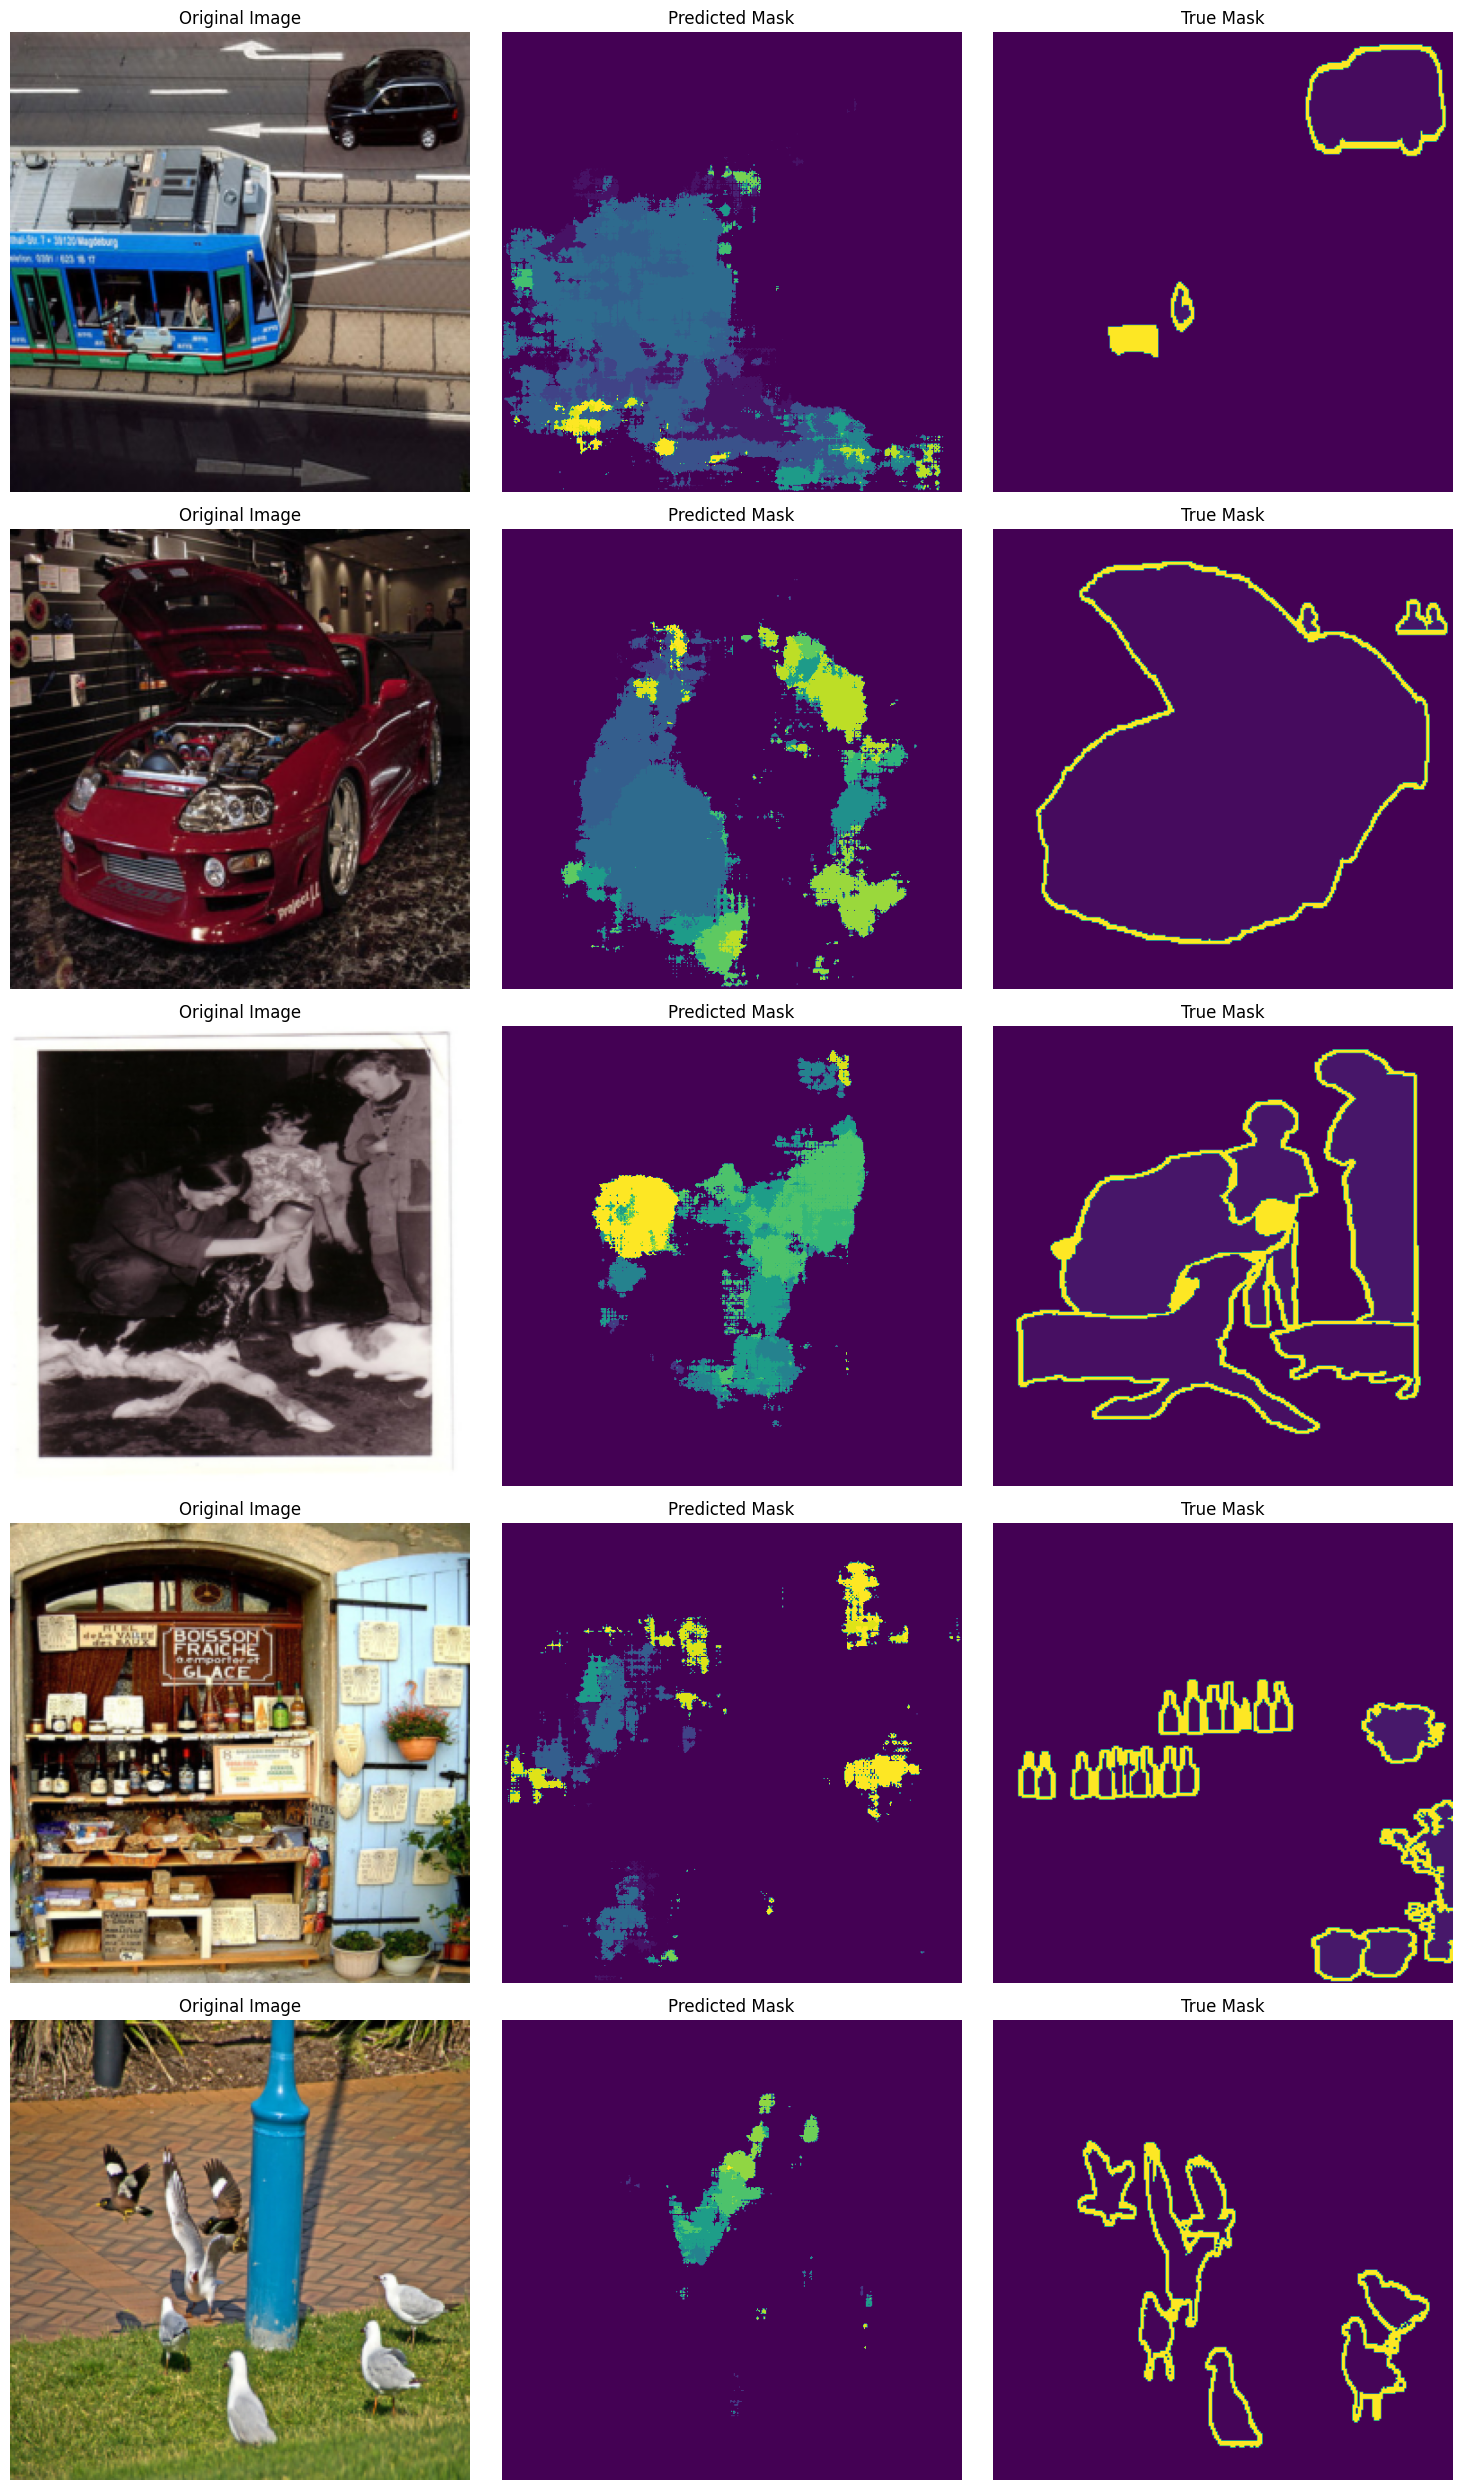

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, device, num_images=5):
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the max index for predicted class

    # Displaying the images, predicted masks, and true masks
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
    
    for i in range(num_images):
        # Since the images and masks are on the device, they need to be brought back to the CPU for visualization
        img = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
        pred_mask = predicted[i].cpu().numpy()
        true_mask = masks[i].cpu().numpy()

        if img.shape[2] == 1:
            img = img.squeeze(2)

        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 1].imshow(pred_mask)
        axs[i, 1].set_title('Predicted Mask')
        axs[i, 2].imshow(true_mask.squeeze(0))
        axs[i, 2].set_title('True Mask')

        # Remove axis
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
visualize_predictions(net, val_loader, device)


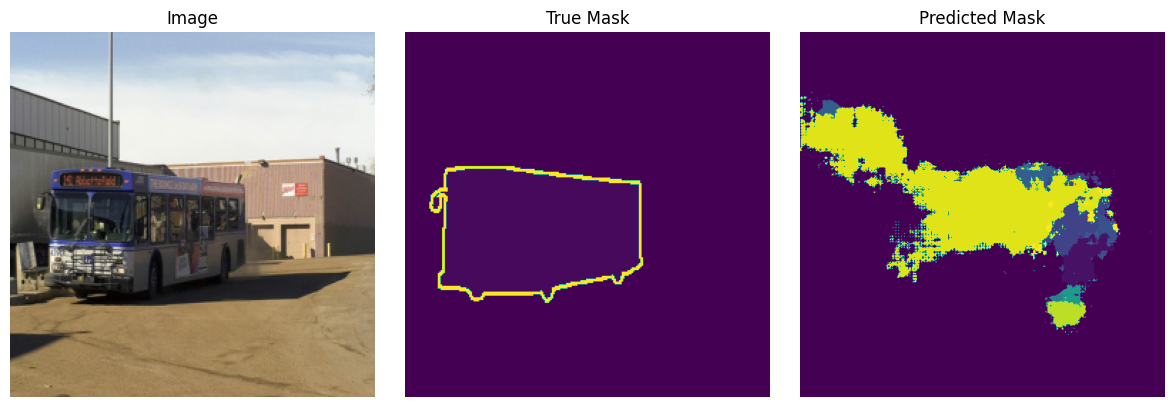

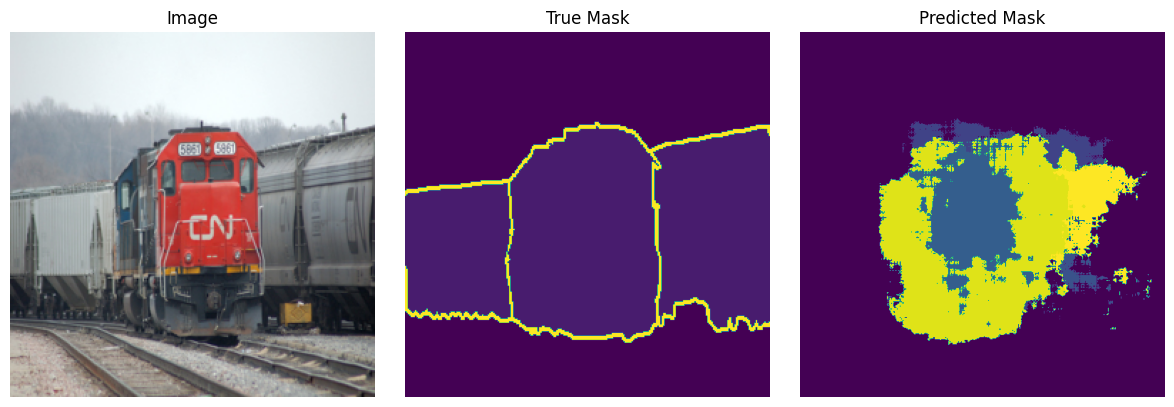

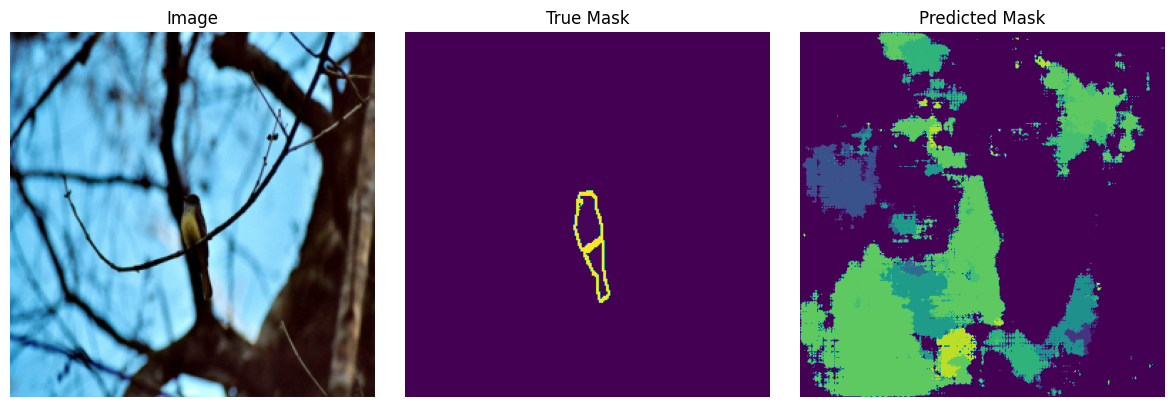

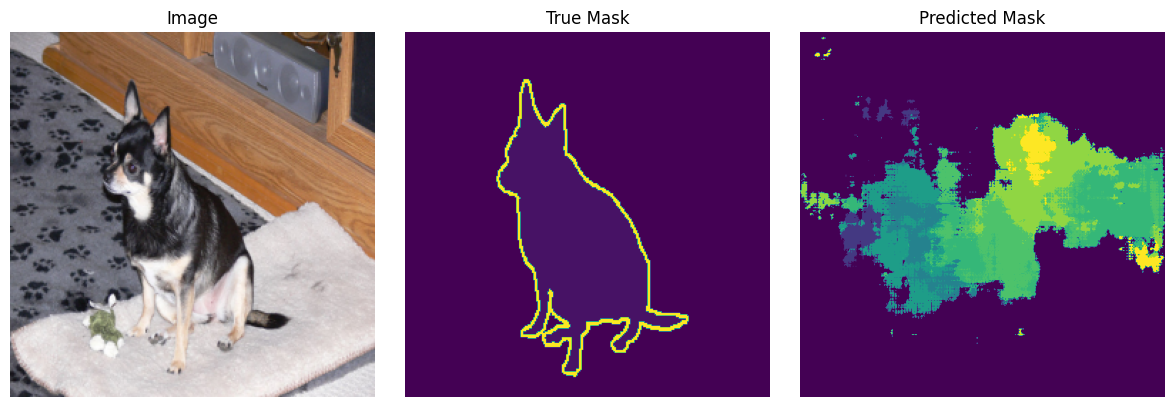

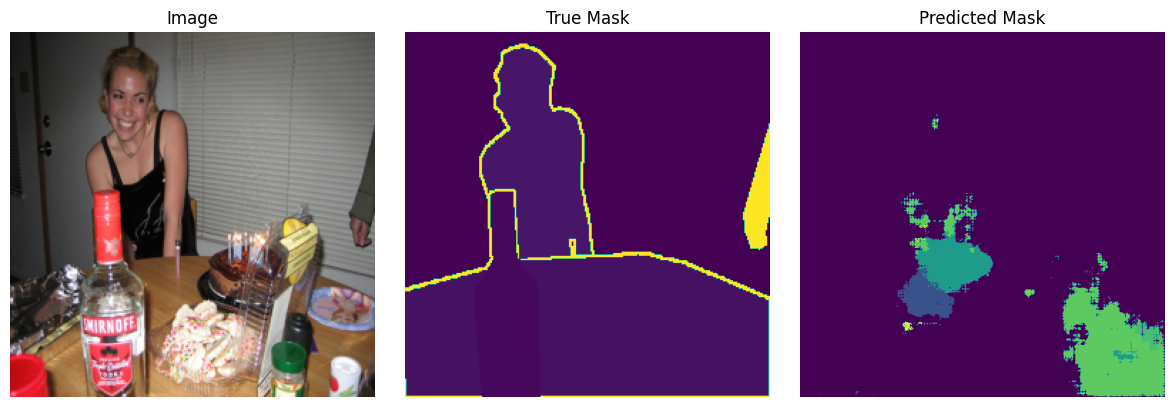

In [47]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_predictions(loader, model, device, num_images=5):
    data_iter = iter(loader)
    images, masks = next(data_iter)

    images = images.to(device)
    masks = masks.squeeze(1).cpu().numpy()  # Squeeze the channel dimension

    # Get the model outputs
    with torch.no_grad():
        outputs = model(images)

    # Apply softmax activation
    probs = F.softmax(outputs, dim=1)  # Apply softmax along the channel dimension
    _, predicted = torch.max(probs, 1)  # Get the predicted class for each pixel
    # print(torch.max(predicted))

    # Convert tensors back to numpy for visualization
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    predicted = predicted.cpu().numpy()
    for i in range(num_images):
        fig, axarr = plt.subplots(1, 3, figsize=(12, 4))

        # Display original image, true mask, and predicted mask
        axarr[0].imshow(images[i])
        axarr[0].set_title('Image')
        axarr[1].imshow(masks[i])
        axarr[1].set_title('True Mask')
        axarr[2].imshow(predicted[i])
        axarr[2].set_title('Predicted Mask')

        # Remove axis ticks
        for ax in axarr:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

visualize_predictions(val_loader, net, device)


In [48]:
data_iter = iter(val_loader)
images, masks = next(data_iter)

images = images.to(device)
masks = masks.squeeze(1).cpu().numpy()  # Squeeze the channel dimension

# Get the model outputs
with torch.no_grad():
    outputs = net(images)

# Apply softmax activation
probs = F.softmax(outputs, dim=1)  # Apply softmax along the channel dimension
_, predicted = torch.max(probs, 1)  # Get the predicted class for each pixel

In [49]:
torch.unique(torch.tensor(masks))

tensor([0.0000, 0.0039, 0.0078, 0.0157, 0.0196, 0.0275, 0.0314, 0.0353, 0.0392,
        0.0471, 0.0510, 0.0549, 0.0588, 0.0667, 0.0745, 0.0784, 1.0000])

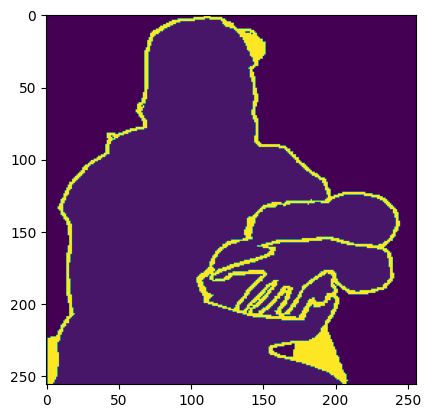

In [50]:
plt.imshow(masks[0])

In [51]:
masks.shape

(32, 256, 256)

In [52]:
outputs.shape

torch.Size([32, 21, 512, 512])

In [53]:
predicted.shape

torch.Size([32, 512, 512])

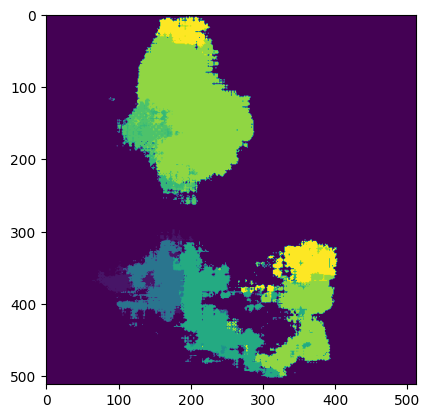

In [54]:
plt.imshow(predicted[0].cpu().numpy())

In [55]:
validate(net, val_loader, criterion, device)

(0.04707282012376068, 0.0024878781718209006)

# Shared Embedding Hypernetwork Test

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from hypernetwork_modules import HyperNetwork
from resnet_blocks import ResNetBlock, IdentityLayer
from primary_net import Embedding, PrimaryNetwork
from segmentation_net import SegmentationNetwork
import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn

import argparse

import torch.optim as optim

from primary_net import PrimaryNetwork

#Data Loader for VOC2012
import torchvision.datasets as datasets

from torchvision.datasets import VOCDetection
import torch

class SharedLatentVectors(nn.Module):
    def __init__(self, z_dim=64):
        super(SharedLatentVectors, self).__init__()
        
        # Define the latent vector sizes
        self.all_zs_size = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1],
                        [2, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2],
                        [4, 2], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4]]

        
        self.zs = nn.ModuleList()
        for size in self.all_zs_size:
            self.zs.append(Embedding(size, z_dim))
    
    def forward(self):
        # Return the shared latent vectors
        return [z for z in self.zs]


In [21]:
class UnifiedNetwork(nn.Module):
    def __init__(self, num_classes, z_dim=64):
        super(UnifiedNetwork, self).__init__()
        
        # Shared latent vectors
        self.all_zs_size = [[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1],
                        [2, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2],
                        [4, 2], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4], [4, 4]]

        
        self.shared_latents = nn.ModuleList()
        for size in self.all_zs_size:
            self.shared_latents.append(Embedding(size, z_dim))

        # self.shared_latents = SharedLatentVectors(z_dim=z_dim)
        
        # Task-specific networks
        self.primary_net = PrimaryNetwork(z_dim=z_dim)
        self.segmentation_net = SegmentationNetwork(num_classes=num_classes, z_dim=z_dim)
        
    def forward(self, x):
        shared_latent_vectors = self.shared_latents
        
        # Classification output
        class_out = self.primary_net(x, shared_latent_vectors)
        
        # Segmentation output
        seg_out = self.segmentation_net(x, shared_latent_vectors)
        
        return class_out, seg_out


In [10]:
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection, VOCSegmentation
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
# from unified_net import UnifiedNetwork

# Transformations for Images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Transformations for Segmentation Masks
target_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

class CustomVOCDataset(VOCDetection):
    def __init__(self, root, year='2012', image_set='train', transform=None, target_transform=None):
        super(CustomVOCDataset, self).__init__(root, year=year, image_set=image_set, transform=transform, target_transform=target_transform)
        self.classes = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

    def __getitem__(self, index):
        img, target = super(CustomVOCDataset, self).__getitem__(index)
        
        lbl = torch.zeros(len(self.classes))
        for obj in target['annotation']['object']:
            if obj['name'] in self.classes:
                class_idx = self.classes.index(obj['name'])
                lbl[class_idx] = 1
        
        return img, lbl

data_dir = 'VOCdevkit/VOC2012/'

# Custom combined dataset
class UnifiedVOCDataset(Dataset):
    def __init__(self, root, year='2012', image_set='train', transform=None, target_transform=None):
        self.classification_dataset = CustomVOCDataset(root=root, year=year, image_set=image_set, transform=transform)
        self.segmentation_dataset = VOCSegmentation(root=root, year=year, image_set=image_set, transform=transform, target_transform=target_transform)

    def __len__(self):
        return len(self.classification_dataset)

    def __getitem__(self, idx):
        img_class, label = self.classification_dataset[idx]
        img_seg, mask = self.segmentation_dataset[idx]
        return img_class, label, mask

train_dataset = UnifiedVOCDataset(root=data_dir, year='2012', image_set='train', transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = UnifiedVOCDataset(root=data_dir, year='2012', image_set='val', transform=transform, target_transform=target_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [25]:
from torch.utils.data import Dataset

class UnifiedVOCDataset(Dataset):
    def __init__(self,  root, year='2012', image_set='train', transform=None, target_transform=None):
        self.classification_dataset = CustomVOCDataset(root=root, year=year, image_set=image_set, transform=transform)
        self.segmentation_dataset = VOCSegmentation(root=root, year=year, image_set=image_set, transform=transform, target_transform=target_transform)

    def __len__(self):
        return max(len(self.classification_dataset), len(self.segmentation_dataset))

    def __getitem__(self, idx):
        idx_classification = idx % len(self.classification_dataset)
        idx_segmentation = idx % len(self.segmentation_dataset)

        img_class, label = self.classification_dataset[idx_classification]
        img_seg, mask = self.segmentation_dataset[idx_segmentation]
        return img_class, label, mask

unified_train_dataset = UnifiedVOCDataset(root=data_dir, year='2012', image_set='train', transform=transform, target_transform=target_transform)
train_loader = torch.utils.data.DataLoader(unified_train_dataset, batch_size=16, shuffle=True, num_workers=4)


In [ ]:
#check the dimension of trainloader images
dataiter = iter(train_loader)
next(dataiter)

In [24]:

# Initialize unified network
net = UnifiedNetwork(num_classes = 21)
net.to(device)

# Losses & Optimizer
classification_criterion = nn.BCEWithLogitsLoss()
segmentation_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 1000
print_freq = 10

for epoch in range(num_epochs):
    net.train()
    running_class_loss = 0.0
    running_seg_loss = 0.0

    for i, (inputs_class, labels, masks) in enumerate(train_loader):
        inputs_class, labels, masks = inputs_class.to(device), labels.to(device), masks.to(device)
        masks = (masks * 255).long().squeeze(1)
        masks = F.interpolate(masks.unsqueeze(1).float(), size=(512, 512), mode='nearest').squeeze(1).long()
        masks[masks == 255] = 0

        optimizer.zero_grad()
        outputs_class, outputs_seg = net(inputs_class)

        # Compute losses for both tasks
        classification_loss = classification_criterion(outputs_class, labels)
        segmentation_loss = segmentation_criterion(outputs_seg, masks)

        # Combine the losses
        combined_loss = classification_loss + segmentation_loss
        combined_loss.backward()

        optimizer.step()

        running_class_loss += classification_loss.item()
        running_seg_loss += segmentation_loss.item()

        # Print statistics
        if i % print_freq == (print_freq - 1):
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Classification Loss: {running_class_loss / print_freq:.3f}, Segmentation Loss: {running_seg_loss / print_freq:.3f}")
            running_class_loss = 0.0
            running_seg_loss = 0.0

# You can add a validation loop similar to the previous code, adjusting for the unified network outputs.

[Epoch 1, Batch 10] Classification Loss: 0.792, Segmentation Loss: 2.964
[Epoch 1, Batch 20] Classification Loss: 0.480, Segmentation Loss: 2.384
[Epoch 1, Batch 30] Classification Loss: 0.316, Segmentation Loss: 1.677
[Epoch 1, Batch 40] Classification Loss: 0.262, Segmentation Loss: 1.455
[Epoch 1, Batch 50] Classification Loss: 0.269, Segmentation Loss: 1.255
[Epoch 1, Batch 60] Classification Loss: 0.243, Segmentation Loss: 1.287
[Epoch 1, Batch 70] Classification Loss: 0.259, Segmentation Loss: 1.344
[Epoch 1, Batch 80] Classification Loss: 0.249, Segmentation Loss: 1.301
[Epoch 1, Batch 90] Classification Loss: 0.241, Segmentation Loss: 1.288
[Epoch 1, Batch 100] Classification Loss: 0.245, Segmentation Loss: 1.263
[Epoch 1, Batch 110] Classification Loss: 0.235, Segmentation Loss: 1.345
[Epoch 1, Batch 120] Classification Loss: 0.236, Segmentation Loss: 1.272
[Epoch 1, Batch 130] Classification Loss: 0.234, Segmentation Loss: 1.241
[Epoch 1, Batch 140] Classification Loss: 0.240

KeyboardInterrupt: 

In [26]:

# Initialize unified network
# net = UnifiedNetwork(num_classes = 21)
# net.to(device)

# Losses & Optimizer
classification_criterion = nn.BCEWithLogitsLoss()
segmentation_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 1000
print_freq = 10

for epoch in range(num_epochs):
    net.train()
    running_class_loss = 0.0
    running_seg_loss = 0.0

    for i, (inputs_class, labels, masks) in enumerate(train_loader):
        inputs_class, labels, masks = inputs_class.to(device), labels.to(device), masks.to(device)
        masks = (masks * 255).long().squeeze(1)
        masks = F.interpolate(masks.unsqueeze(1).float(), size=(512, 512), mode='nearest').squeeze(1).long()
        masks[masks == 255] = 0

        optimizer.zero_grad()
        outputs_class, outputs_seg = net(inputs_class)

        # Compute losses for both tasks
        classification_loss = classification_criterion(outputs_class, labels)
        segmentation_loss = segmentation_criterion(outputs_seg, masks)

        # Combine the losses
        combined_loss = classification_loss + segmentation_loss
        combined_loss.backward()

        optimizer.step()

        running_class_loss += classification_loss.item()
        running_seg_loss += segmentation_loss.item()

        # Print statistics
        if i % print_freq == (print_freq - 1):
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Classification Loss: {running_class_loss / print_freq:.3f}, Segmentation Loss: {running_seg_loss / print_freq:.3f}")
            running_class_loss = 0.0
            running_seg_loss = 0.0

# You can add a validation loop similar to the previous code, adjusting for the unified network outputs.

[Epoch 1, Batch 10] Classification Loss: 0.198, Segmentation Loss: 1.188
